<a href="https://colab.research.google.com/github/G0rav/image_similarity_search/blob/main/image_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task

 Image similarity search using multiple approaches.

 - Should be accurate
 - Should work in real-time
 - Should be efficient and scalable


 ## Working

 Extracting latent embeddings from images and comparing them in feature space. The closer the features of two images are in this space, the more similar they are considered to be.

# Data

Fashion MNIST - Closest to Shoppin's use case


In [4]:
# Imports necessary libraries
import os
import tensorflow as tf

def load_fashion_mnist_data():
  """Loads the Fashion-MNIST dataset.

  Returns:
      tuple: A tuple containing the training data (images and labels)
             and the testing data (images and labels).
  """
  (x_train_og, y_train_og), (x_test_og, y_test_og) = tf.keras.datasets.fashion_mnist.load_data()
  return (x_train_og, y_train_og), (x_test_og, y_test_og)

# Load the Fashion-MNIST dataset
(x_train_og, y_train_og), (x_test_og, y_test_og) = load_fashion_mnist_data()

# Print the shape of the training images to inspect the data
print("Shape of x_train_og:", x_train_og.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape of x_train_og: (60000, 28, 28)


# Resnet50

In [8]:
# Imports necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
size = (224, 224)  # Desired image size for ResNet50

def preprocess_image(image_path):
    """
    Preprocesses an image for ResNet50.

    Loads an image from the given path, resizes it, converts it to an array,
    expands dimensions to add a batch dimension, and applies ResNet50-specific preprocessing.

    Args:
        image_path (str): Path to the image file.

    Returns:
        numpy.ndarray: Preprocessed image array.
    """
    img = load_img(image_path, target_size=size)  # Load and resize image
    img_array = img_to_array(img)  # Convert to NumPy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Apply ResNet50 preprocessing
    return img_array

def extract_features(model, img, image_path=None):
    """
    Extracts features from an image using the given model.

    If an image path is provided, it preprocesses the image first.
    Otherwise, it assumes the image is already preprocessed.

    Args:
        model (keras.Model): The model to use for feature extraction.
        img (numpy.ndarray): The image data (optional, used if image_path is None).
        image_path (str, optional): Path to the image file. Defaults to None.

    Returns:
        numpy.ndarray: Extracted features.
    """
    if image_path:
        img = preprocess_image(image_path)  # Preprocess image if path is given
    features = model.predict(img)  # Extract features using the model
    return features

def compute_similarity(query_features, all_features):
    """
    Computes cosine similarity between a query image and a set of images.

    Args:
        query_features (numpy.ndarray): Features of the query image.
        all_features (numpy.ndarray): Features of all images in the database.

    Returns:
        numpy.ndarray: Similarity scores between the query and all images.
    """
    similarities = cosine_similarity(query_features, all_features)  # Calculate cosine similarity
    return similarities

def load_data(ntrain, ntest):
    """
    Loads and preprocesses Fashion MNIST data for training and testing.

    Converts images to RGB, resizes them, and applies ResNet50-specific preprocessing.
    Splits the test data into test and validation sets.

    Args:
        ntrain (int): Number of training samples.
        ntest (int): Number of test samples.

    Returns:
        tuple: A tuple containing preprocessed training and test data:
            (x_train_resized, y_train, x_val_resized, y_val, x_test_resized, y_test)
    """
    # Train data preprocessing
    x_train_images_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(x_train_og[:ntrain], axis=-1))
    x_train_images_rgb = tf.image.resize(x_train_images_rgb, size)
    x_train_resized = preprocess_input(x_train_images_rgb.numpy())
    y_train = y_train_og[:ntrain].astype(np.float32)

    # Test, Val data splitting
    x_test, x_val, y_test, y_val = train_test_split(
        x_test_og[:ntest],
        y_test_og[:ntest],
        test_size=0.25, random_state=0, shuffle=True
    )

    # Test data preprocessing
    x_val_images_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(x_val, axis=-1))
    x_val_images_rgb = tf.image.resize(x_val_images_rgb, size)
    x_test_images_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(x_test, axis=-1))
    x_test_images_rgb = tf.image.resize(x_test_images_rgb, size)

    x_val_resized = preprocess_input(x_val_images_rgb.numpy())
    x_test_resized = preprocess_input(x_test_images_rgb.numpy())

    y_val = y_val.astype(np.float32)
    y_test = y_test.astype(np.float32)

    return x_train_resized, y_train, x_val_resized, y_val, x_test_resized, y_test

In [11]:
# Loading Dataset
x_train1, y_train1, x_val1, y_val1, x_test1, y_test1 = load_data(ntrain=4_000, ntest=500)

# Print the shapes of the data components
print("Shape of x_train1:", x_train1.shape)
print("Shape of y_train1:", y_train1.shape)
print("Shape of x_val1:", x_val1.shape)
print("Shape of y_val1:", y_val1.shape)
print("Shape of x_test1:", x_test1.shape)
print("Shape of y_test1:", y_test1.shape)

Shape of x_train1: (4000, 224, 224, 3)
Shape of y_train1: (4000,)
Shape of x_val1: (125, 224, 224, 3)
Shape of y_val1: (125,)
Shape of x_test1: (375, 224, 224, 3)
Shape of y_test1: (375,)


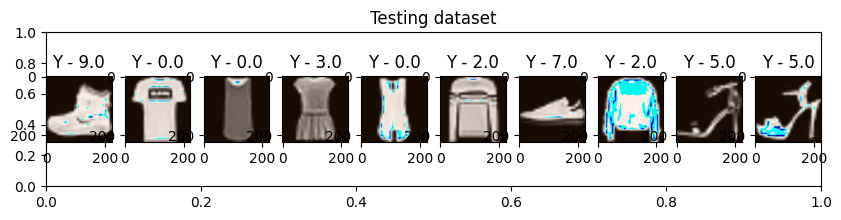

In [6]:
# Displays the first 10 images from the dataset along with their labels.

plt.figure(figsize=(10, 2))
plt.title("Testing dataset")

# Iterate through the first 10 images and labels
for i, idx in enumerate(x_train1[:10]):
    plt.subplot(1, 10, i+1 )
    plt.imshow((x_train1[i]+128).astype("uint8"))
    plt.title(f"Y - {y_train1[i]}")
plt.show()

## Model Finetuning

Finetuning a pre-trained ResNet50 model

In [95]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Get number of classes based on unique labels in the training set
nclasses = len(np.unique(y_train1))
print("Total classes -", nclasses)

# Load ResNet50 model pre-trained on ImageNet, excluding the top classification layer
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',  # Load weights pre-trained on ImageNet
    input_tensor=None,
    input_shape=size+(3,),
    pooling='avg',
    classes=1000,
)

# Freeze the base model to retain pre-learned features
base_model.trainable = False

# Add custom layers for fine-tuning
x = tf.keras.layers.Dropout(0.25)(base_model.output)
embedd_layer = tf.keras.layers.Dense(128, activation='relu', name='embedd_layer')(x)
x = tf.keras.layers.BatchNormalization()(embedd_layer)  # Normalize activations
x = tf.keras.layers.Dropout(0.25)(x)  # Apply dropout for regularization
output = tf.keras.layers.Dense(nclasses, activation='softmax')(x)  # Final output layer for classification

# Construct the complete model with the base model input and custom output
model = Model(inputs=base_model.input, outputs=output)

model.summary()

Total classes - 10


In [13]:
# Compile the model with Adam optimizer and sparse categorical cross-entropy loss function
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04),
    loss='sparse_categorical_crossentropy',         # because we do not have one-hot encoded labels
    metrics=['accuracy']
)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Train the model for 35 epochs
history = model.fit(
    x_train1,
    y_train1,
    epochs=35,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test1, y_test1),
    callbacks=[reduce_lr]  # Apply learning rate reduction callback
)

# Save the trained model
model.save('resnet50.keras')


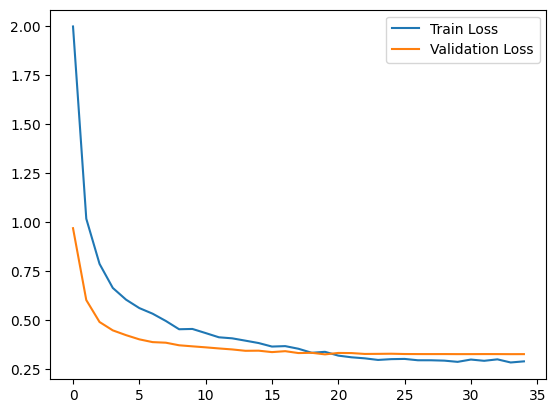

In [15]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [16]:
# Re-compile and train for a further 10 epochs with a constant learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-7),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

# Further training for 10 more epochs
history1 = model.fit(
    x_train1,
    y_train1,
    epochs=10,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test1, y_test1),
)

# Save the trained model again
model.save('resnet50.keras')

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 315ms/step - accuracy: 0.8958 - loss: 0.2979 - val_accuracy: 0.8827 - val_loss: 0.3268
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - accuracy: 0.8917 - loss: 0.3044 - val_accuracy: 0.8827 - val_loss: 0.3272
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.8886 - loss: 0.2997 - val_accuracy: 0.8827 - val_loss: 0.3269
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.9052 - loss: 0.2824 - val_accuracy: 0.8827 - val_loss: 0.3268
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - accuracy: 0.9099 - loss: 0.2720 - val_accuracy: 0.8827 - val_loss: 0.3267
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.8908 - loss: 0.3075 - val_accuracy: 0.8827 - val_loss: 0.3266
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.9002 - loss: 0.2940 - val_accuracy: 0.8827 - val_loss: 0.3265
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - accuracy: 0.8904 - loss: 0.3172 - val_accu

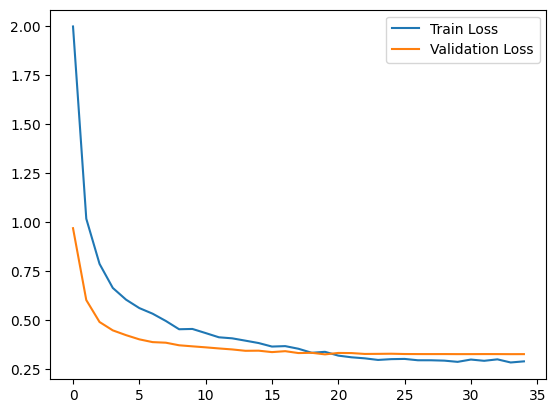

In [17]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [57]:
# Predict on the test set
predicted_labels = model.predict(x_test1[:20])
predicted_labels = np.argmax(predicted_labels, axis=1)  # Get the class with the highest probability

# Print classification report for the first 20 test samples
classification_report_output = classification_report(y_test1[:20], predicted_labels, zero_division=0)
print(classification_report_output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86         4
         1.0       1.00      1.00      1.00         1
         2.0       1.00      1.00      1.00         3
         3.0       0.50      0.50      0.50         2
         4.0       0.67      1.00      0.80         2
         5.0       1.00      1.00      1.00         1
         6.0       0.75      0.75      0.75         4
         7.0       1.00      1.00      1.00         1
         9.0       1.00      1.00      1.00         2

    accuracy                           0.85        20
   macro avg       0.88      0.89      0.88        20
weighted avg       0.87      0.85      0.85        20



## Similarity Inference

In [25]:
# Taking embedd layer
embedd_layer = model.get_layer('embedd_layer')

# Create a new model that outputs the embedding layer
embedd_model = Model(inputs=model.input, outputs=embedd_layer.output)

# checking summary
embedd_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,849,984 (90.98 MB)

 Trainable params: 262,272 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [26]:
# Get embeddings for the first 100 training samples
train_embeddings = embedd_model.predict(x_train1[:100], batch_size=32, verbose=1)
print(train_embeddings.shape)  # Print the shape of the embeddings
print(train_embeddings)  # Print the embeddings


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
(100, 128)
[[0.         0.         0.01623878 ... 0.         3.4431787  2.7417812 ]
 [0.         3.0341985  0.9613788  ... 0.5863517  0.         1.6452767 ]
 [0.         0.55103093 1.679903   ... 0.         0.08149601 1.6959256 ]
 ...
 [2.339788   0.         2.4371278  ... 0.         0.         1.684001  ]
 [0.8433647  0.         2.337984   ... 0.         0.         1.3727831 ]
 [0.         2.1150622  1.1274091  ... 1.519107   2.157957   2.5680268 ]]


(224, 224, 3)
9.0


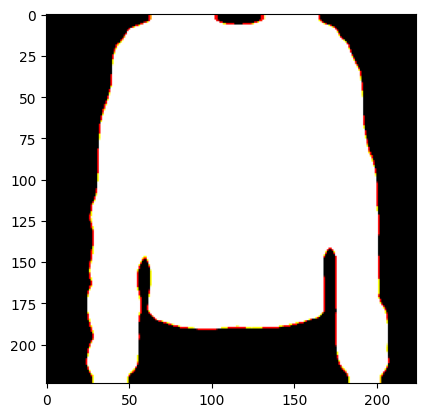

In [27]:
# Select a query image from the test set
query_index = 0
query_image = x_test1[query_index]
print(query_image.shape)  # Print the shape of the query image

print(f"Label of query image: {y_train1[query_index]}")
plt.imshow(query_image)  # Display the query image
plt.show()

In [32]:
# Extract features of the query image using the embedding model
query_features = extract_features(embedd_model, query_image[np.newaxis, ...])
print(query_features)  # Print the extracted features

# Compute the similarity between the query image and training set embeddings
similarities = compute_similarity(query_features, train_embeddings)

# Sort the similarities in descending order and get the sorted indices
sorted_indices = np.argsort(similarities[0])[::-1]
print(sorted_indices)  # Print the indices of the most similar images

array([19, 68, 29, 75,  7, 28, 22, 39, 96, 33, 18, 40, 49, 76, 27, 24, 95,
       53, 65, 25, 32, 56, 45,  4, 47, 73, 77, 94, 21, 54, 67,  5, 37, 72,
       55, 92, 20, 66,  2, 57, 10, 26, 70, 31, 91,  3, 61, 98, 80, 59, 23,
       50, 34, 84, 16, 11, 78, 51, 64, 71, 17, 58, 44, 86,  1, 99, 97, 88,
       48, 35, 38, 81, 69, 74,  0, 60,  9, 90,  8, 93, 42, 79, 89, 82, 83,
       13, 12, 15, 52, 46, 43, 36, 85, 62, 41, 63, 87,  6, 30, 14])

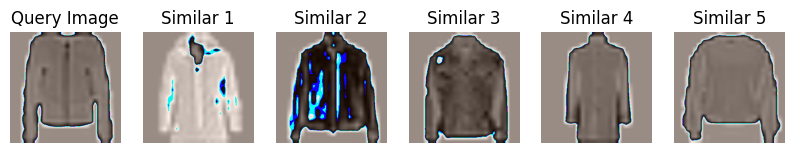

In [34]:
# Visualize similar images for the given query image
def visualize_similar_images(query_image, similar_indices, dataset, y, num_similar=5):
    """
    Visualize similar images based on their similarity to a query image.

    Parameters:
    - query_image: The query image to be compared
    - similar_indices: Indices of the most similar images
    - dataset: The dataset from which the similar images are selected
    - y: The labels corresponding to the dataset
    - num_similar: The number of similar images to display (default is 5)
    """
    plt.figure(figsize=(10, 2))  # Create a figure for displaying the images

    # Display the query image
    plt.subplot(1, num_similar + 1, 1)
    plt.imshow(query_image.astype("uint8"))
    plt.title("Query Image")
    plt.axis('off')

    # Display similar images based on the sorted indices
    for i, idx in enumerate(similar_indices[:num_similar]):
        plt.subplot(1, num_similar + 1, i + 2)
        plt.imshow(dataset[idx].astype("uint8"))
        plt.title(f"Similar {i + 1}")
        plt.axis('off')

    # Show the plot
    plt.show()

# Visualize the top 5 similar images to the query image
visualize_similar_images(query_image, sorted_indices, x_train1[:100], y_train1[:100], num_similar=5)


## Evaluate




In [92]:
def calculate_metrics(query_idx, all_embeddings, labels, top_k=5):
    """
    Calculate precision, recall, and retrieval accuracy for image similarity search.

    Args:
        query_idx (int): Index of the query image
        all_embeddings (Tensor): Embeddings of all images
        labels (Array): Ground truth labels for all images
        top_k (int): Number of top results to consider

    Returns:
        dict: Dictionary containing precision, recall, and retrieval accuracy metrics
    """
    # Get query embedding and label
    query_embedding = all_embeddings[query_idx]
    query_label = labels[query_idx].item()

    # Calculate similarities and get top k indices
    similarities = (all_embeddings @ query_embedding.T)
    top_indices = np.argsort(similarities)[::-1][1:top_k + 1]  # Exclude query image

    # Convert labels to numpy if they're tensors
    if torch.is_tensor(labels):
        labels_np = labels.cpu().numpy()
    else:
        labels_np = np.array(labels)

    # Get predicted labels for top k results
    predicted_labels = labels_np[top_indices]

    # Calculate metrics
    relevant_items = (predicted_labels == query_label).sum().item()
    total_relevant = (labels_np == query_label).sum().item() - 1  # Subtract 1 to exclude query image

    precision = relevant_items / top_k
    recall = relevant_items / total_relevant if total_relevant > 0 else 0

    # Calculate retrieval accuracy (whether the correct class appears in top k)
    retrieval_accuracy = 1.0 if relevant_items > 0 else 0.0

    return {
        'precision': precision,
        'recall': recall,
        'retrieval_accuracy': retrieval_accuracy
    }

def evaluate_model(all_embeddings, labels, num_samples=100, top_k=5):
    """
    Evaluate model performance across multiple queries.

    Args:
        all_embeddings (torch.Tensor): Embeddings of all images
        labels (Tensor): Ground truth labels for all images
        num_samples (int): Number of random queries to evaluate
        top_k (int): Number of top results to consider

    Returns:
        dict: Dictionary containing average metrics
    """
    # Random sample of indices to evaluate
    indices = np.random.choice(len(labels), size=num_samples, replace=False)

    # Initialize metrics
    total_precision = 0
    total_recall = 0
    total_retrieval_accuracy = 0

    # Calculate metrics for each query
    for idx in indices:
        metrics = calculate_metrics(idx, all_embeddings, labels, top_k)
        total_precision += metrics['precision']
        total_recall += metrics['recall']
        total_retrieval_accuracy += metrics['retrieval_accuracy']

    # Calculate averages
    avg_metrics = {
        'avg_precision': total_precision / num_samples,
        'avg_recall': total_recall / num_samples,
        'avg_retrieval_accuracy': total_retrieval_accuracy / num_samples
    }

    return avg_metrics


In [93]:
# Evaluate the model
evaluation_results = evaluate_model(train_embeddings, y_train1[:100], num_samples=50, top_k=10)

print("\nModel Evaluation Results:")
print(f"Average Precision: {evaluation_results['avg_precision']:.4f}")
print(f"Average Recall: {evaluation_results['avg_recall']:.4f}")
print(f"Average Retrieval Accuracy: {evaluation_results['avg_retrieval_accuracy']:.4f}")


Model Evaluation Results:
Average Precision: 0.4840
Average Recall: 0.5280
Average Retrieval Accuracy: 0.9800


# Autoencoder


Implemented an Autoencoder using to reconstruct input images.


The model is trained to minimize the pixel-wise reconstruction error between the input image and the
reconstructed image. The goal is to learn a compact, lower-dimensional representation (embedding) of the
input images, which can later be used for tasks like image similarity.

In [24]:
# Importing necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [25]:
# Preprocessing data: Normalize the pixel values and expand dimensions
x_train1 = x_train_og[:2000].astype("float32") / 255.0
x_test1 = x_test_og[:2000].astype("float32") / 255.0

x_train1 = np.expand_dims(x_train1, axis=-1)
x_test1 = np.expand_dims(x_test1, axis=-1)

# printing shape
print(x_train1.shape)

(2000, 28, 28, 1)


## Train

In [26]:
def downblock(filters, filter_size, previous_layer, dropout=True):
    """
    A downsampling block that applies Batch Normalization, ReLU activation,
    convolutional layers, optional dropout, and max pooling.
    Includes residual connections for better gradient flow.

    Args:
        filters (int): Number of filters for the Conv2D layers.
        filter_size (int): Size of the convolutional filters.
        previous_layer (tf.Tensor): Input tensor from the previous layer.
        dropout (bool): Whether to apply dropout after the first convolutional layer.

    Returns:
        tuple: The output tensor of the block and the pooled tensor.
    """
    # Batch normalization and activation for the input
    x = layers.BatchNormalization()(previous_layer)
    x = layers.Activation("relu")(x)

    # First convolutional layer
    x = layers.Conv2D(filters, filter_size, padding="same")(x)

    # Optional dropout
    if dropout:
        x = layers.Dropout(0.2)(x)

    # Batch normalization and activation for the second convolutional layer
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, filter_size, padding="same")(x)

    # Residual connection
    residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)
    x = layers.add([x, residual])  # Add back residual connection

    # Final activation and max pooling
    x = layers.Activation("relu")(x)
    p = layers.MaxPooling2D(2)(x)

    return x, p


def upblock(filters, filter_size, previous_layer, layer_to_concat, dropout=True):
    """
    An upsampling block that applies transposed convolution, concatenation with
    a corresponding downsampling layer, Batch Normalization, ReLU activation,
    convolutional layers, optional dropout, and residual connections.

    Args:
        filters (int): Number of filters for the Conv2D layers.
        filter_size (int): Size of the convolutional filters.
        previous_layer (tf.Tensor): Input tensor from the previous layer.
        layer_to_concat (tf.Tensor): Tensor from the corresponding downsampling layer.
        dropout (bool): Whether to apply dropout after the first convolutional layer.

    Returns:
        tf.Tensor: The output tensor of the block.
    """
    # Transposed convolution for upsampling
    x = layers.Conv2DTranspose(filters, filter_size, strides=2, padding="same")(previous_layer)
    # Concatenation with the corresponding downsampling layer
    concat = layers.concatenate([x, layer_to_concat])

    # Batch normalization and activation for the concatenated tensor
    x = layers.BatchNormalization()(concat)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, filter_size, padding="same")(x)

    # Optional dropout
    if dropout:
        x = layers.Dropout(0.2)(x)

    # Batch normalization and activation for the second convolutional layer
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, filter_size, padding="same")(x)

    # Residual connection
    residual = layers.Conv2D(filters, 1, padding="same")(concat)
    x = layers.add([x, residual])  # Add back residual connection

    # Final activation
    x = layers.Activation("relu")(x)

    return x


# Input layer for the image data
input_shape = x_train1.shape[1:]  # Shape of the input images
input_layer = tf.keras.layers.Input(shape=input_shape)

# Initial convolutional layer
layer1 = layers.Conv2D(16, 3, padding="same")(input_layer)

# Encoder (downsampling)
conv1, pool1 = downblock(32, 3, layer1)
conv2, pool2 = downblock(64, 3, pool1)

# Latent space (embedding layer)
x = tf.keras.layers.Flatten()(pool2)
embed = tf.keras.layers.Dense(128, activation='relu', name="embed")(x)

# Decoder (upsampling)
x = tf.keras.layers.Dense(7 * 7 * 64, activation='relu')(embed)  # Reshape to feature map dimensions
x = tf.keras.layers.Reshape((7, 7, 64))(x)

upconv1 = upblock(64, 3, x, conv2)
upconv2 = upblock(64, 3, upconv1, conv1)

# Output layer for reconstructed image
output = tf.keras.layers.Conv2D(1, (3, 3), activation=None, padding='same')(upconv2)

# Create the model
model = Model(input_layer, output)
encoder = Model(input_layer, embed)

# Display the model architecture
model.summary()


------ (None, 14, 14, 64)
------ (None, 28, 28, 64)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_150 (Conv2D)       │ (None, 28, 28, 16)     │            160 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_88    │ (None, 28, 28, 16)     │             64 │ conv2d_150[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_132            │ (None, 28, 28, 16)     │              0 │ batch_normalization_8… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_151 (Conv2D)       │ (None, 28, 28, 32)     │          4,640 │ activation_132[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_44 (Dropout)      │ (None, 28, 28, 32)     │              0 │ conv2d_151[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_89    │ (None, 28, 28, 32)     │            128 │ dropout_44[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_133            │ (None, 28, 28, 32)     │              0 │ batch_normalization_8… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_152 (Conv2D)       │ (None, 28, 28, 32)     │          9,248 │ activation_133[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_153 (Conv2D)       │ (None, 28, 28, 32)     │            544 │ conv2d_150[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_44 (Add)              │ (None, 28, 28, 32)     │              0 │ conv2d_152[0][0],      │
│                           │                        │                │ conv2d_153[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_134            │ (None, 28, 28, 32)     │              0 │ add_44[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_39          │ (None, 14, 14, 32)     │              0 │ activation_134[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_90    │ (None, 14, 14, 32)     │            128 │ max_pooling2d_39[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_135            │ (None, 14, 14, 32)     │              0 │ batch_normalization_9… │
│ (Activation)         

 Total params: 1,172,097 (4.47 MB)

 Trainable params: 1,171,105 (4.47 MB)

 Non-trainable params: 992 (3.88 KB)

In [27]:
# Compile the model using Adam optimizer and loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04),
    loss='mean_squared_error',
    metrics=['accuracy']
)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Train the model on the training data
history = model.fit(
    x_train1,
    x_train1,  # Using the same data for input and target (autoencoder)
    epochs=25,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test1, x_test1),
    callbacks=[reduce_lr]
)


Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4457 - loss: 0.3765 - val_accuracy: 0.4996 - val_loss: 0.1682 - learning_rate: 1.0000e-04
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.4932 - loss: 0.1179 - val_accuracy: 0.4996 - val_loss: 0.1535 - learning_rate: 1.0000e-04
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.5058 - loss: 0.0703 - val_accuracy: 0.4996 - val_loss: 0.1357 - learning_rate: 1.0000e-04
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.5060 - loss: 0.0489 - val_accuracy: 0.4996 - val_loss: 0.1241 - learning_rate: 1.0000e-04
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.5118 - loss: 0.0362 - val_accuracy: 0.4996 - val_loss: 0.1039 - learning_rate: 1.0000e-04
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.5140 - loss: 0.0284 - val_accuracy: 0.5000 - val_loss: 0.0830 - learning_rate: 1.0000e-04
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5140 - loss:

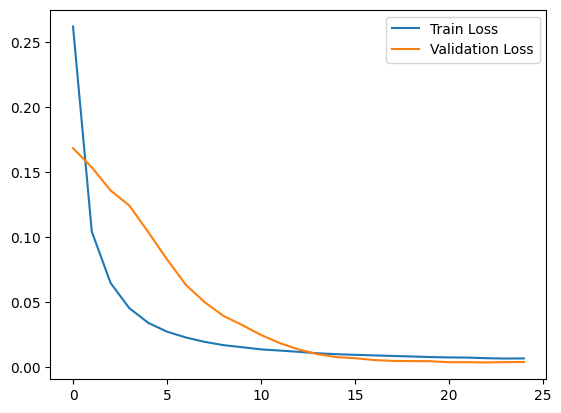

In [28]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


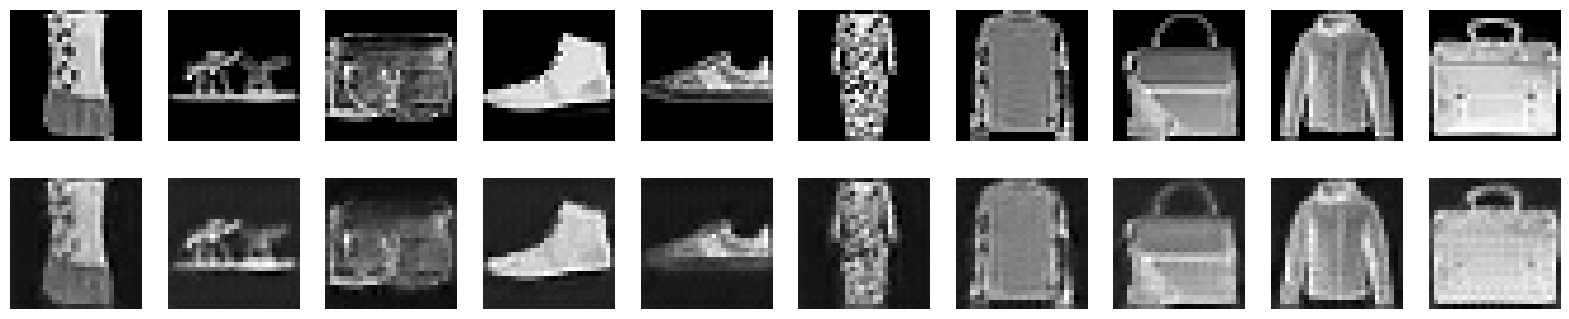

In [29]:
def visualize_reconstruction(encoder, model, data, n=10):
    """
    Visualizes original and reconstructed images from the test set.

    Args:
        encoder: Encoder model to generate embeddings.
        model: Full autoencoder model to reconstruct images.
        data: Data to be visualized (test images).
        n: Number of images to visualize.
    """
    # Randomly select n images from the data
    idx = np.random.choice(len(data), n)
    original = data[idx]
    reconstructed = model.predict(original)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original image
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap="gray")
        plt.axis("off")

        # Reconstructed image
        plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

# Visualize the reconstruction of the test set
visualize_reconstruction(encoder, model, x_test1)

In [32]:
def get_embeddings(encoder, data):
    """
    Extracts embeddings (feature vectors) for the given data using the encoder.

    Args:
        encoder: Encoder model to generate embeddings.
        data: Data to extract embeddings for.

    Returns:
        embeddings: The extracted embeddings for the data.
    """
    embeddings = encoder.predict(data)
    return embeddings

# Get embeddings for the test set
embeddings = get_embeddings(encoder, x_test1[:20])
embeddings.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


(20, 128)

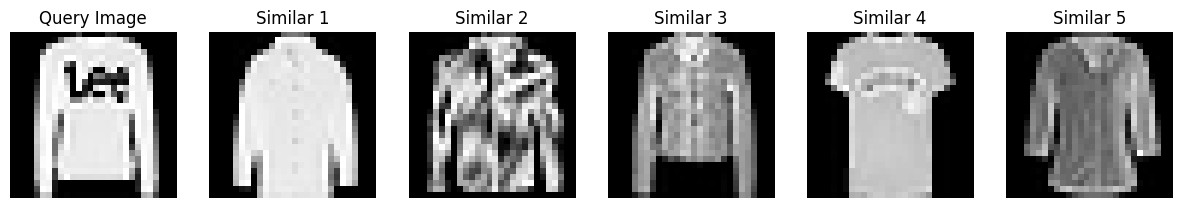

In [33]:
## Find Similar Images

def find_similar_images(embeddings, data, query_idx, top_k=5):
    """
    Finds and visualizes top_k most similar images to the query image.

    Args:
        embeddings: Embedding vectors for the entire dataset.
        data: Data to find similar images in.
        query_idx: Index of the query image in the dataset.
        top_k: Number of similar images to display.
    """
    query_embedding = embeddings[query_idx].reshape(1, -1)
    similarities = cosine_similarity(query_embedding, embeddings).flatten()
    top_indices = np.argsort(similarities)[::-1][1:top_k+1]

    # Display query image and the most similar images
    plt.figure(figsize=(15, 3))
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(data[query_idx].squeeze(), cmap="gray")
    plt.title("Query Image")
    plt.axis("off")

    for i, idx in enumerate(top_indices):
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(data[idx].squeeze(), cmap="gray")
        plt.title(f"Similar {i+1}")
        plt.axis("off")
    plt.show()

# Find and visualize similar images for a given query image
query_image_idx = 1
find_similar_images(embeddings, x_test1, query_image_idx, top_k=5)


## Evaluate


L2 norm not cosine - since we used mse in loss

In [42]:
# Get embeddings and labels
x_test_embeddings = get_embeddings(encoder, x_test1[:500])
y_test_labels = y_test_og[:500]  # Adjust based on dataset size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


In [50]:
import numpy as np

def calculate_metrics(query_idx, all_embeddings, labels, top_k=5):
    """
    Calculate precision, recall, and retrieval accuracy for image similarity search.

    Args:
        query_idx (int): Index of the query image
        all_embeddings (np.ndarray): Embeddings of all images
        labels (np.ndarray): Ground truth labels for all images
        top_k (int): Number of top results to consider

    Returns:
        dict: Dictionary containing precision, recall, and retrieval accuracy metrics
    """
    # Get query embedding and label
    query_embedding = all_embeddings[query_idx]
    query_label = labels[query_idx]

    # Calculate L2 distances and get top k indices
    distances = np.linalg.norm(all_embeddings - query_embedding, axis=1)
    top_indices = np.argsort(distances)[1:top_k + 1]  # Exclude query image

    # Get predicted labels for top k results
    predicted_labels = labels[top_indices]

    # Calculate metrics
    relevant_items = np.sum(predicted_labels == query_label)
    total_relevant = np.sum(labels == query_label) - 1  # Subtract 1 to exclude query image

    precision = relevant_items / top_k
    recall = relevant_items / total_relevant if total_relevant > 0 else 0

    # Calculate retrieval accuracy (whether the correct class appears in top k)
    retrieval_accuracy = 1.0 if relevant_items > 0 else 0.0

    return {
        'precision': precision,
        'recall': recall,
        'retrieval_accuracy': retrieval_accuracy
    }

def evaluate_model(all_embeddings, labels, num_samples=100, top_k=5):
    """
    Evaluate model performance across multiple queries.

    Args:
        all_embeddings (np.ndarray): Embeddings of all images
        labels (np.ndarray): Ground truth labels for all images
        num_samples (int): Number of random queries to evaluate
        top_k (int): Number of top results to consider

    Returns:
        dict: Dictionary containing average metrics
    """
    # Random sample of indices to evaluate
    indices = np.random.choice(len(labels), size=num_samples, replace=False)

    # Initialize metrics
    total_precision = 0
    total_recall = 0
    total_retrieval_accuracy = 0

    # Calculate metrics for each query
    for idx in indices:
        metrics = calculate_metrics(idx, all_embeddings, labels, top_k)
        total_precision += metrics['precision']
        total_recall += metrics['recall']
        total_retrieval_accuracy += metrics['retrieval_accuracy']

    # Calculate averages
    avg_metrics = {
        'avg_precision': total_precision / num_samples,
        'avg_recall': total_recall / num_samples,
        'avg_retrieval_accuracy': total_retrieval_accuracy / num_samples
    }

    return avg_metrics


In [51]:
# Evaluate the model
evaluation_results = evaluate_model(x_test_embeddings, y_test_labels, num_samples=10, top_k=5)

print("\nModel Evaluation Results:")
print(f"Average Precision: {evaluation_results['avg_precision']:.4f}")
print(f"Average Recall: {evaluation_results['avg_recall']:.4f}")
print(f"Average Retrieval Accuracy: {evaluation_results['avg_retrieval_accuracy']:.4f}")


Model Evaluation Results:
Average Precision: 0.6200
Average Recall: 0.0688
Average Retrieval Accuracy: 0.9000


# Siamese


In [ ]:
# Import necessary libraries
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
# Load the Fashion MNIST dataset
(x_train_val, y_train_val), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train_val.shape  # checking shape

(60000, 28, 28)

In [ ]:
# Convert data to float32 for computation
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")

# Split the data into training and validation sets
x_train, x_val = x_train_val[:5000], x_train_val[5000:]
y_train, y_val = y_train_val[:5000], y_train_val[5000:]
# Free up memory
del x_train_val, y_train_val

In [ ]:
def make_pairs(x, y):
    """
    Create pairs of images and their corresponding labels.
    Positive pairs (same class) are labeled as 0.
    Negative pairs (different classes) are labeled as 1.

    Args:
        x (ndarray): Array of images.
        y (ndarray): Array of labels corresponding to the images.

    Returns:
        tuple: A tuple containing pairs of images and their labels.
    """
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        x1 = x[idx1]
        label1 = y[idx1]

        # Create a positive pair
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        pairs.append([x1, x2])
        labels.append(0)

        # Create a negative pair
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:  # Ensure the negative label is different
            label2 = random.randint(0, num_classes - 1)
        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        pairs.append([x1, x2])
        labels.append(1)

    return np.array(pairs), np.array(labels).astype("float32")


In [ ]:
# Generate pairs for training, validation, and testing
pairs_train, labels_train = make_pairs(x_train, y_train)
pairs_val, labels_val = make_pairs(x_val, y_val)
pairs_test, labels_test = make_pairs(x_test, y_test)

# Checking shape
pairs_train.shape

(10000, 2, 28, 28)

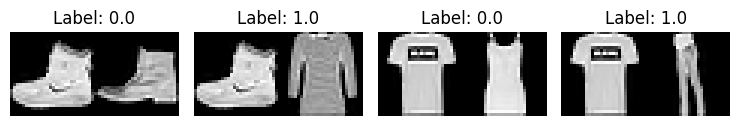

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """
    Visualize paired images with their labels or predictions.

    Args:
        pairs (ndarray): Pairs of images to visualize.
        labels (ndarray): True labels of the pairs.
        to_show (int): Number of pairs to show. Default is 6.
        num_col (int): Number of columns in the visualization grid. Default is 3.
        predictions (ndarray): Model predictions for test pairs. Default is None.
        test (bool): If True, include predictions in the visualization. Default is False.
    """

    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        # Concatenate the pair of images horizontally
        ax.imshow(tf.keras.ops.concatenate([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()



visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

## Modeling and Train


In [ ]:
# Define the Euclidean distance function for the Siamese network
def euclidean_distance(vects):
    """
    Compute the Euclidean distance between two vectors.

    Args:
        vects (tuple): A tuple containing two tensors to compute the distance.

    Returns:
        Tensor: The Euclidean distance as a tensor.
    """
    x, y = vects
    sum_square = tf.keras.ops.sum(tf.keras.ops.square(x - y), axis=1, keepdims=True)
    return tf.keras.ops.sqrt(tf.keras.ops.maximum(sum_square, keras.backend.epsilon()))

# Define the embedding network
input = keras.layers.Input((28, 28, 1))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)

# Create the Siamese network
input_1 = keras.layers.Input((28, 28, 1))
input_2 = keras.layers.Input((28, 28, 1))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [tower_1, tower_2]
)
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

# Display network
siamese.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_17            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_18             │ (None, 10)             │          5,318 │ input_layer_16[0][0],  │
│ (Functional)              │                        │                │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 1)              │              0 │ functional_18[0][0],   │
│                           │                        │                │ functional_18[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 1)              │              4 │ lambda_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1)              │              2 │ batch_normalization_8… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,324 (20.80 KB)

 Trainable params: 4,808 (18.78 KB)

 Non-trainable params: 516 (2.02 KB)

In [ ]:
embedding_network.summary() # checking embedding architecture

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 24, 24, 4)           │             104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 12, 12, 4)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 8, 8, 16)            │           1,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 4, 4, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,318 (20.77 KB)

 Trainable params: 4,804 (18.77 KB)

 Non-trainable params: 514 (2.01 KB)

In [ ]:
def loss(margin=1):
    """
    Contrastive loss function.

    Args:
        margin (float): Margin for separating positive and negative pairs.

    Returns:
        Function: A function to compute the contrastive loss.
    """
    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):

        square_pred = tf.keras.ops.square(y_pred)
        margin_square = tf.keras.ops.square(tf.keras.ops.maximum(margin - (y_pred), 0))
        return tf.keras.ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss


# Compiling
siamese.compile(loss=loss(margin=1), optimizer="adam", metrics=["accuracy"])

In [ ]:
# Prepare the input data for training, validation, and testing by splitting pairs into separate arrays for the Siamese network.

# Separate pairs into individual images for the training set
x_train_1 = pairs_train[:, 0]  # First images in the training pairs
x_train_2 = pairs_train[:, 1]  # Second images in the training pairs

# Separate pairs into individual images for the validation set
x_val_1 = pairs_val[:, 0]  # First images in the validation pairs
x_val_2 = pairs_val[:, 1]  # Second images in the validation pairs

# Separate pairs into individual images for the test set
x_test_1 = pairs_test[:, 0]  # First images in the test pairs
x_test_2 = pairs_test[:, 1]  # Second images in the test pairs


In [ ]:
x_test_1.shape, labels_test.shape    # checking shape

((20000, 28, 28), (20000,))

In [ ]:
# Train the Siamese network using the training data and validate with the validation data
history = siamese.fit(
    [x_train_1, x_train_2],  # Input images for the Siamese network
    labels_train,            # Labels for the training data
    validation_data=([x_val_1, x_val_2], labels_val),  # Validation data and labels
    batch_size=16,           # Number of samples per batch
    epochs=15,               # Number of training epochs
)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 105s 162ms/step - accuracy: 0.7879 - loss: 0.2085 - val_accuracy: 0.8472 - val_loss: 0.1298
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 92ms/step - accuracy: 0.8353 - loss: 0.1326 - val_accuracy: 0.8704 - val_loss: 0.0997
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.8555 - loss: 0.1092 - val_accuracy: 0.8761 - val_loss: 0.0929
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 85ms/step - accuracy: 0.8623 - loss: 0.1030 - val_accuracy: 0.8900 - val_loss: 0.0850
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 86ms/step - accuracy: 0.8668 - loss: 0.0997 - val_accuracy: 0.8881 - val_loss: 0.0845
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 87ms/step - accuracy: 0.8786 - loss: 0.0911 - val_accuracy: 0.8862 - val_loss: 0.0848
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 87ms/step - accuracy: 0.8690 - loss: 0.0963 - val_accuracy: 0.8904 - val_loss: 0.0818
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 91ms/step - accuracy: 0.8893 - loss: 0.0858 

In [ ]:
# Saving model
siamese.save('siamese.keras')

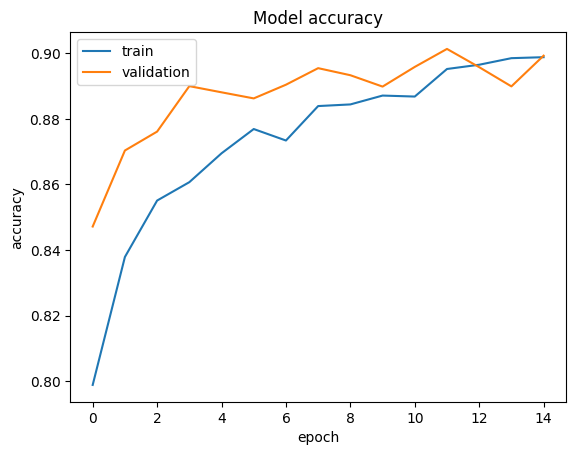

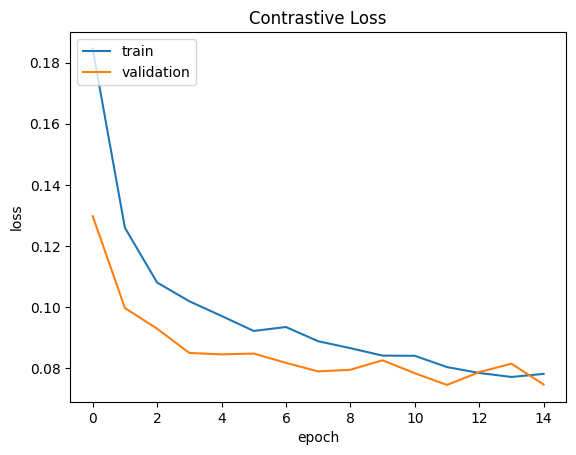

In [ ]:

# Define a function to plot training and validation metrics over epochs
def plt_metric(history, metric, title, has_valid=True):
    """
    Plot the training and validation metrics over epochs.

    Parameters:
    - history: dict
        Training history containing metrics like accuracy and loss.
    - metric: str
        The metric to plot (e.g., 'accuracy', 'loss').
    - title: str
        The title of the plot.
    - has_valid: bool, optional (default=True)
        Whether validation metrics are present in the history.

    Returns:
    - None
    """
    # Plot the training metric
    plt.plot(history[metric], label="Train")

    # Plot the validation metric if available
    if has_valid:
        plt.plot(history["val_" + metric], label="Validation")

    # Add legends, title, and labels
    plt.legend(loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("Epoch")
    plt.grid(True)  # Add a grid for better visualization
    plt.show()

# Plot the model accuracy during training and validation
plt_metric(history=history.history, metric="accuracy", title="Model Accuracy")

# Plot the contrastive loss during training and validation
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

In [ ]:
# Evaluate the Siamese network on the test set
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
results

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8984 - loss: 0.0757


[0.07748904079198837, 0.8962500095367432]

In [ ]:
# Make predictions using the Siamese network on the test set
predictions = siamese.predict([x_test_1, x_test_2])
predictions

625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step


array([[0.01764811],
       [0.9831689 ],
       [0.00398097],
       ...,
       [0.9913797 ],
       [0.2890347 ],
       [0.9950655 ]], dtype=float32)

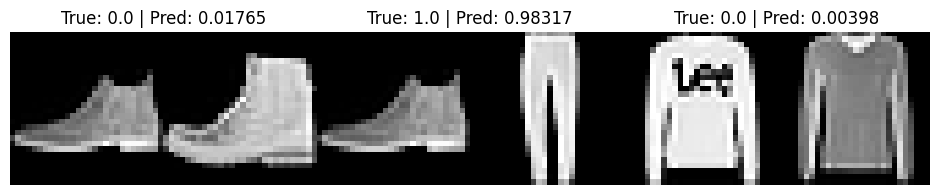

In [ ]:
# Visualize test samples with their predictions
visualize(pairs_test, labels_test, to_show=3, predictions=predictions, test=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


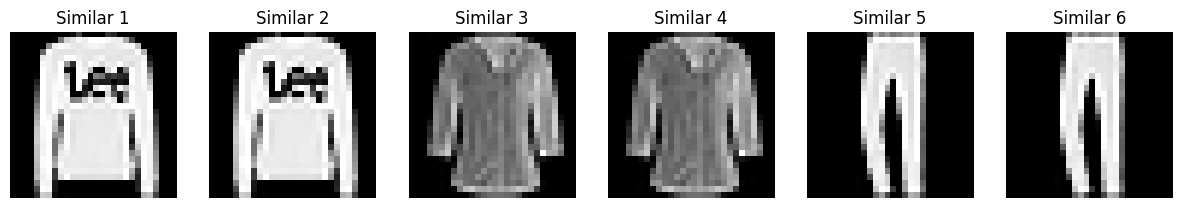

In [ ]:

def find_similar_images_siamese(model, data, query_idx, top_k=5):
    """
    Find and visualize the top-k most similar images to a given query image using a Siamese network.

    Parameters:
    - model: tf.keras.Model
        The embedding network used to generate embeddings for the images.
    - data: np.ndarray
        The dataset of images to search for similar images.
    - query_idx: int
        Index of the query image in the dataset.
    - top_k: int, optional (default=5)
        Number of most similar images to display.

    Returns:
    - None
    """
    # Generate embeddings for all images in the dataset
    embeddings = model.predict(data)

    # Extract the embedding of the query image
    query_embedding = embeddings[query_idx].reshape(1, -1)

    # Compute distances between the query embedding and all other embeddings
    distances = np.linalg.norm(embeddings - query_embedding, axis=1)

    # Get indices of the top-k + 1 closest images (including the query itself)
    top_indices = np.argsort(distances)[:top_k + 1]

    # Plot the query image and its most similar images
    plt.figure(figsize=(15, 3))

    # Display the query image
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(data[query_idx].squeeze(), cmap="gray")
    plt.title("Query Image")
    plt.axis("off")

    # Display the top-k most similar images
    for i, idx in enumerate(top_indices[1:]):  # Skip the first image (query itself)
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(data[idx].squeeze(), cmap="gray")
        plt.title(f"Similar {i + 1}")
        plt.axis("off")

    plt.show()


# Define the index of the query image and find similar images
query_image_idx = 2  # Index of the query image in the test set
find_similar_images_siamese(embedding_network, x_test_1[:10], query_image_idx, top_k=5)

## Evaluate

In [ ]:
# loading model
siamese = tf.keras.models.load_model("/content/siamese.keras", custom_objects={
    'euclidean_distance': euclidean_distance,
    'contrastive_loss': loss
    })

In [ ]:
# extracting embedding network
embedding_network = siamese.get_layer('functional_11')

embedding_network.summary()  # Check the model summary

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 24, 24, 4)           │             104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 12, 12, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 8, 8, 16)            │           1,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 4, 4, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,318 (20.77 KB)

 Trainable params: 4,804 (18.77 KB)

 Non-trainable params: 514 (2.01 KB)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Encode the test labels to numeric format
le = LabelEncoder()
y_test_encoded = le.fit_transform(labels_test)

def compute_metrics_siamese(embedding_model, data, labels, top_k=5):
    """
    Compute evaluation metrics for a Siamese model: Precision@k, Recall@k,
    Retrieval Accuracy, and Classification Report.

    Parameters:
    - embedding_model: tf.keras.Model
        The trained embedding network for generating image embeddings.
    - data: np.ndarray
        The dataset of images for evaluation.
    - labels: np.ndarray
        The true labels for the dataset, encoded as integers.
    - top_k: int, optional (default=5)
        Number of top similar images to consider for evaluation.

    Returns:
    - avg_precision: float
        Average Precision@k across the dataset.
    - avg_recall: float
        Average Recall@k across the dataset.
    - avg_retrieval_accuracy: float
        Average retrieval accuracy (at least one correct match) across the dataset.
    - report: str
        Detailed classification report including precision, recall, and F1-score.
    """
    # Generate embeddings for all images
    embeddings = embedding_model.predict(data)

    n = len(embeddings)
    precisions = []
    recalls = []
    retrieval_accuracies = []

    # Store true and predicted labels for classification report
    true_labels = []
    predicted_labels = []

    for i in range(n):
        # Compute cosine similarity for the query image
        query_embedding = embeddings[i].reshape(1, -1)
        distances = np.linalg.norm(embeddings - query_embedding, axis=1)
        top_indices = np.argsort(distances)[1:top_k + 1]  # Exclude the query itself

        # Retrieve true labels of the top-k images
        relevant_labels = labels[top_indices]
        query_label = labels[i]

        # Calculate Precision@k and Recall@k
        num_relevant = np.sum(relevant_labels == query_label)
        precision = num_relevant / top_k
        recall = num_relevant / np.sum(labels == query_label)  # Total relevant items in the dataset

        # Calculate retrieval accuracy (1 if at least one match, else 0)
        retrieval_accuracy = 1 if num_relevant > 0 else 0

        # Append metrics for aggregation
        precisions.append(precision)
        recalls.append(recall)
        retrieval_accuracies.append(retrieval_accuracy)

        # Store true and predicted labels for classification report
        true_labels.extend([query_label] * len(top_indices))
        predicted_labels.extend(relevant_labels)

    # Aggregate metrics
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_retrieval_accuracy = np.mean(retrieval_accuracies)

    # Generate classification report
    report = classification_report(true_labels, predicted_labels, zero_division=0)

    return avg_precision, avg_recall, avg_retrieval_accuracy, report


# Evaluate the Siamese network embeddings
precision, recall, retrieval_accuracy, classification_report_output = compute_metrics_siamese(
    embedding_network, x_test_1, y_test_encoded, top_k=5
)

# Print the evaluation results
print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"Retrieval Accuracy: {retrieval_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report_output)

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Precision@5: 0.4941
Recall@5: 0.0002
Retrieval Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.49      0.49     50000
           1       0.49      0.50      0.49     50000

    accuracy                           0.49    100000
   macro avg       0.49      0.49      0.49    100000
weighted avg       0.49      0.49      0.49    100000



# CLIP


Using CLIP model to find similar images

In [58]:
# Loading necessary libraries
import torch
from transformers import CLIPProcessor, CLIPModel
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [59]:
# Set the device to GPU if available,
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the CLIP processor for image preprocessing
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Grayscale(3),  # Convert grayscale to 3-channel RGB
    transforms.Resize((224, 224)),  # Resize images to 224x224 (required for CLIP)
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize pixel values
])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

In [60]:
# Load the FashionMNIST dataset with transformations
dataset = FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Create a DataLoader for batch processing
data_loader = DataLoader(dataset, batch_size=64, shuffle=False)

# Get the first batch of images and labels
images, labels = next(iter(data_loader))
print("Shape of images:", images.shape)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.4MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 169kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.20MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 24.8MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



torch.Size([64, 3, 224, 224])

## Model Load

In [61]:
# Load the CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [70]:
def get_clip_embeddings(images, model, processor):
    """
    Generate normalized image embeddings using the CLIP model.

    Args:
        images (torch.Tensor): Batch of images (B x C x H x W).
        model (CLIPModel): Pretrained CLIP model.
        processor (CLIPProcessor): CLIP processor for preprocessing.

    Returns:
        torch.Tensor: Normalized image embeddings.
    """
    # Unnormalize the images (convert to original pixel scale)
    images = (images * 0.5) + 0.5

    with torch.no_grad():
        # Process images and move to the appropriate device
        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
        # Get image features from the CLIP model
        embeddings = model.get_image_features(**inputs)
        # Normalize the embeddings
        embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)
    return embeddings


# Initialize lists to store embeddings and labels
all_embeddings = []
all_labels = []

# Generating embeddings for the dataset
for batch in data_loader:
    batch_images = batch[0].to(device)
    batch_embeddings = get_clip_embeddings(batch_images, model, processor)
    all_embeddings.append(batch_embeddings)
    all_labels.append(batch[1])

    break

all_embeddings = torch.cat(all_embeddings)
all_labels = torch.cat(all_labels)

# checking shapes
print(all_embeddings.shape)
print(all_labels.shape)


torch.Size([64, 512])
torch.Size([64])


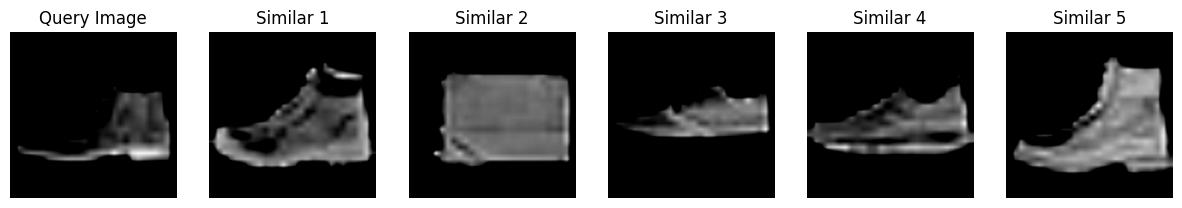

In [65]:
def find_similar_images_clip(query_idx, all_embeddings, images, top_k=5):
    """
    Find and display the most similar images to a query image based on CLIP embeddings.

    Args:
        query_idx (int): Index of the query image.
        all_embeddings (torch.Tensor): Normalized embeddings of all images.
        images (torch.Tensor): Original images corresponding to the embeddings.
        top_k (int): Number of similar images to display.

    Returns:
        None
    """

    # Get the embedding of the query image
    query_embedding = all_embeddings[query_idx].unsqueeze(0)
    # Compute cosine similarities between the query embedding and all embeddings
    similarities = (all_embeddings @ query_embedding.T).squeeze(1).cpu().numpy()
    # Get indices of the top-k most similar images
    top_indices = np.argsort(similarities)[::-1][:top_k + 1]  # +1 to include the query image

    # Plot the query image and its most similar images
    plt.figure(figsize=(15, 3))
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(images[query_idx].permute(1, 2, 0).numpy(), cmap="gray")
    plt.title("Query Image")
    plt.axis("off")

    for i, idx in enumerate(top_indices[1:]):
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(images[idx].permute(1, 2, 0).numpy(), cmap="gray")
        plt.title(f"Similar {i+1}")
        plt.axis("off")
    plt.show()

# Testing with a query image
query_image_idx = 0
find_similar_images_clip(query_image_idx, all_embeddings, images, top_k=5)

## Evaluate

In [83]:
def calculate_metrics(query_idx, all_embeddings, labels, top_k=5):
    """
    Calculate precision, recall, and retrieval accuracy for image similarity search.

    Args:
        query_idx (int): Index of the query image
        all_embeddings (torch.Tensor): Embeddings of all images
        labels (torch.Tensor): Ground truth labels for all images
        top_k (int): Number of top results to consider

    Returns:
        dict: Dictionary containing precision, recall, and retrieval accuracy metrics
    """
    # Get query embedding and label
    query_embedding = all_embeddings[query_idx].unsqueeze(0)
    query_label = labels[query_idx].item()

    # Calculate similarities and get top k indices
    similarities = (all_embeddings @ query_embedding.T).squeeze(1).cpu().numpy()
    top_indices = np.argsort(similarities)[::-1][1:top_k + 1]  # Exclude query image

    # Convert labels to numpy if they're tensors
    if torch.is_tensor(labels):
        labels_np = labels.cpu().numpy()
    else:
        labels_np = np.array(labels)

    # Get predicted labels for top k results
    predicted_labels = labels_np[top_indices]

    # Calculate metrics
    relevant_items = (predicted_labels == query_label).sum().item()
    total_relevant = (labels_np == query_label).sum().item() - 1  # Subtract 1 to exclude query image

    precision = relevant_items / top_k
    recall = relevant_items / total_relevant if total_relevant > 0 else 0

    # Calculate retrieval accuracy (whether the correct class appears in top k)
    retrieval_accuracy = 1.0 if relevant_items > 0 else 0.0

    return {
        'precision': precision,
        'recall': recall,
        'retrieval_accuracy': retrieval_accuracy
    }

def evaluate_model(all_embeddings, labels, num_samples=100, top_k=5):
    """
    Evaluate model performance across multiple queries.

    Args:
        all_embeddings (torch.Tensor): Embeddings of all images
        labels (torch.Tensor): Ground truth labels for all images
        num_samples (int): Number of random queries to evaluate
        top_k (int): Number of top results to consider

    Returns:
        dict: Dictionary containing average metrics
    """
    # Random sample of indices to evaluate
    indices = np.random.choice(len(labels), size=num_samples, replace=False)

    # Initialize metrics
    total_precision = 0
    total_recall = 0
    total_retrieval_accuracy = 0

    # Calculate metrics for each query
    for idx in indices:
        metrics = calculate_metrics(idx, all_embeddings, labels, top_k)
        total_precision += metrics['precision']
        total_recall += metrics['recall']
        total_retrieval_accuracy += metrics['retrieval_accuracy']

    # Calculate averages
    avg_metrics = {
        'avg_precision': total_precision / num_samples,
        'avg_recall': total_recall / num_samples,
        'avg_retrieval_accuracy': total_retrieval_accuracy / num_samples
    }

    return avg_metrics


In [85]:
# Evaluate the model
evaluation_results = evaluate_model(all_embeddings, all_labels, num_samples=50, top_k=10)

print("\nModel Evaluation Results:")
print(f"Average Precision: {evaluation_results['avg_precision']:.4f}")
print(f"Average Recall: {evaluation_results['avg_recall']:.4f}")
print(f"Average Retrieval Accuracy: {evaluation_results['avg_retrieval_accuracy']:.4f}")


Model Evaluation Results:
Average Precision: 0.2540
Average Recall: 0.4495
Average Retrieval Accuracy: 0.9800


# END